In [1]:
import sys
sys.path.append("../Modules/")
sys.path.append("../")
import os

import pandas as pd
import numpy as np

from configobj import ConfigObj
from configobj import flatten_errors
from validate import Validator
    
import logging

#fmt = 'logging.Formatter(''%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
fmt = '%(levelname)s_%(name)s-%(funcName)s(): - %(message)s'
logging.basicConfig(level=logging.INFO, format=fmt)
logger = logging.getLogger(__name__)


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
allTrialData = pd.read_pickle('../allTrialData.pickle')


In [4]:
def removeOutliers(allTrialData,columnName,stdRange=3):
    outliers = np.abs(allTrialData[columnName]-allTrialData[columnName].mean()) > (stdRange*allTrialData[columnName].std())
    allTrialData[columnName] = allTrialData[columnName].mask(outliers)
    return allTrialData

# Create an array for matlabby averaging across dimensions 

###  Something is going on, here.  Is this just an effect of ball size?  If so, look at only normal trials.

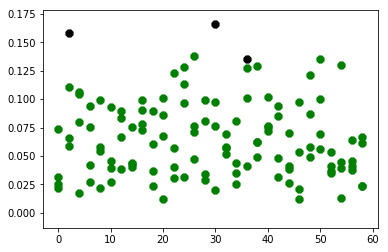

In [5]:
p, ax = plt.subplots(1, 1) 

idx = np.logical_and(allTrialData['blockNumber'] == 1, allTrialData['ipdRatio'] == 1) 
idxCaught = np.logical_and(allTrialData['ballCaughtQ']==1,idx)

x = allTrialData[idxCaught].index
y = allTrialData[idxCaught][('catchingError','2D')]
c = ax.scatter(x,y,c='g',s=60,marker='8')

idxMissed = np.logical_and(allTrialData['ballCaughtQ']==0,idx)
x = allTrialData[idxMissed].index
y = allTrialData[idxMissed][('catchingError','2D')]
m = ax.scatter(x,y,c='k',s=60,marker='8')

### Calculate percent caught

In [6]:

fixDf_ipd_bl_sub = allTrialData.groupby(['ipdRatio',
                                          'blockNumber',
                                          'fileName'])

k = fixDf_ipd_bl_sub['ballCaughtQ'].groups.keys()
nReps = len(fixDf_ipd_bl_sub['ballCaughtQ'].get_group(k[0]))


allTrialData.groupby(['ipdRatio','blockNumber']).groups.keys()
pctCaught_ipd_passLoc_bl_sub = fixDf_ipd_bl_sub['ballCaughtQ'].agg(np.sum)/nReps*100
pctCaught_ipd_passLoc_bl_sub[0.5,2]

fileName
exp_data-2019-4-25-11-22     96.666667
exp_data-2019-4-26-13-4      86.666667
exp_data-2019-4-26-8-52      96.666667
exp_data-2019-4-29-13-18    100.000000
Name: ballCaughtQ, dtype: float64

In [7]:
fixDf_ipd_passLoc_bl_sub = allTrialData.groupby(['ipdRatio',
                                                  'passingLocX',
                                                  'blockNumber',
                                                  'fileName'])


ipdRatioList = list(np.sort(allTrialData.groupby('ipdRatio').groups.keys()))
passingLocXList = list(np.sort(allTrialData.groupby('passingLocX').groups.keys()))
blockList = list(allTrialData.groupby('blockNumber').groups.keys())
fileNames = list(allTrialData.groupby('fileName').groups.keys())

numIpd = len(ipdRatioList)
numPassingLoc = len(passingLocXList)
numBlock = len(blockList)
numSub = len(fileNames)

catchErr_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])
stdCatchErr_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])

catchErrX_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])
stdCatchErrX_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])

catchErrY_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])
stdCatchErrY_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])

pctCaught_ipd_pass_bl_sub = np.zeros([numIpd,numPassingLoc,numBlock, numSub])

fileNames_sub = []
for (ipd,pLoc,bl,sub), data in fixDf_ipd_passLoc_bl_sub:
    # Iterate through groups, while keeping track of which group we're in.
    # The tuple (,pLoc,bl,sub) contains the group indices
    # The variable data is a dataframe containing rows in that group 
    
    # Convert group indices to numeric indices into their value lists
    # ...what is the index of a  of 0.5 in the ipdRatioList?
    ipdIdx  = [i for i, s in enumerate(ipdRatioList) if ipd == s]
    plocIdx  = [i for i, s in enumerate(passingLocXList) if pLoc == s]  
    blIdx  = [i for i, s in enumerate(blockList) if bl == s]
    subIdx  = [i for i, s in enumerate(fileNames) if sub == s]


    catchErr_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','2D')].mean() *100
    stdCatchErr_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','2D')].std()*100
    
    catchErrX_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','X')].mean()*100
    stdCatchErrX_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','X')].std()*100

    catchErrY_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','Y')].mean()*100
    stdCatchErrY_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','Y')].std()*100
    
    nReps = float(len(data['ballCaughtQ']))
    pctCaught_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data['ballCaughtQ'].sum()/nReps*100.0

    #stdCatchErr_ipd_pass_bl_sub[ipdIdx,plocIdx,blIdx,subIdx]  = data[('catchingError','2D')].std()


#  Pct caught all subs

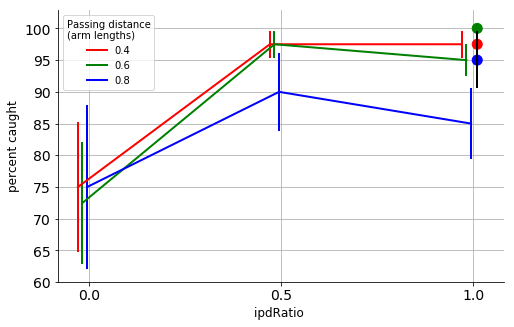

In [8]:
plotSubData = True

##############
nSubs = np.shape(catchErr_ipd_pass_bl_sub)[3]
pctCaught_ipd_passLoc_bl  = np.nanmean(pctCaught_ipd_pass_bl_sub,axis=3)
stdPctCaught_ipd_passLoc_bl = np.nanstd(pctCaught_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)
#pctCaught_ipd_passLoc_bl_sub

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)

# Block 1
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = pctCaught_ipd_passLoc_bl[:,pIdx,1]
    yerr = stdPctCaught_ipd_passLoc_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
#######

bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(pctCaught_ipd_passLoc_bl[2,:,bIdx]) , 
           y = pctCaught_ipd_passLoc_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(pctCaught_ipd_passLoc_bl[2,:,bIdx]), 
            y = pctCaught_ipd_passLoc_bl[2,:,bIdx],
            yerr = stdPctCaught_ipd_passLoc_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('percent caught', fontsize=12)
ax.set_xlabel('ipdRatio ', fontsize=12)
# ax.tick_params(axis='both', which='major', labelsize=12)

#ax.set_ylim([-.1,.4])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=14)

p.set_facecolor('w')

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)

fName = outDir + 'meanCatchingRates.png'
plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)


# Plot 2D catching error for all subjects

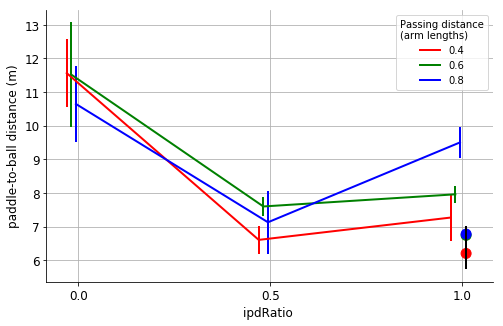

In [9]:
plotSubData = True

##############
nSubs = np.shape(catchErr_ipd_pass_bl_sub)[3]
catchErr_ipd_pass_bl  = np.nanmean(catchErr_ipd_pass_bl_sub,axis=3)
stdCatchErr_ipd_pass_bl = np.nanstd(stdCatchErr_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)

p, ax = plt.subplots(1, 1) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = catchErr_ipd_pass_bl[:,pIdx,1]
    yerr = stdCatchErr_ipd_pass_bl[:,pIdx,1]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    

bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(catchErr_ipd_pass_bl[2,:,bIdx]) , 
           y = catchErr_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(catchErr_ipd_pass_bl[2,:,bIdx]), 
            y = catchErr_ipd_pass_bl[2,:,bIdx],
            yerr = stdCatchErr_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('paddle-to-ball distance (m)', fontsize=12)
ax.set_xlabel('ipdRatio ', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

#ax.set_ylim([-.1,.4])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=12)

p.set_facecolor('w')
outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)

fName = outDir + 'meanCatchingError2D.png'
plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)


# catching error on X

In [10]:
# stdCatchErrX_ipd_pass_bl[2,:,bIdx][0]

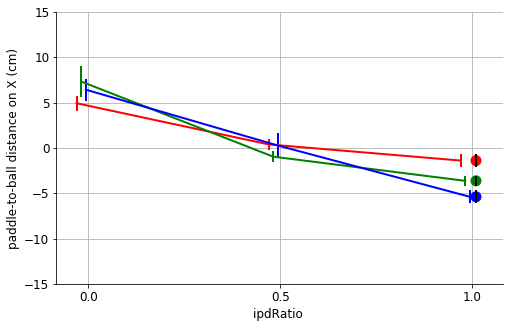

In [11]:
plotSubData = True

##############
nSubs = np.shape(catchErrX_ipd_pass_bl_sub)[3]
catchErrX_ipd_pass_bl  = np.nanmean(catchErrX_ipd_pass_bl_sub,axis=3)
stdCatchErrX_ipd_pass_bl = np.nanstd(stdCatchErrX_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)


p, ax = plt.subplots(1, 1,) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2

bIdx = 1
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = catchErrX_ipd_pass_bl[:,pIdx,bIdx]
    yerr = stdCatchErrX_ipd_pass_bl[:,pIdx,bIdx]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
# Block 1
cList = ['r','g','b']
ax.scatter(x = [1+.01] * len(catchErrX_ipd_pass_bl[2,:,bIdx]) , 
           y = catchErrX_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(catchErrX_ipd_pass_bl[2,:,bIdx]), 
            y = catchErrX_ipd_pass_bl[2,:,bIdx],
            yerr=stdCatchErrX_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('paddle-to-ball distance on X (m)\n<-undershoot overshoot->', fontsize=12)
ax.set_xlabel('ipdRatio ', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_ylim([-15,15])
ax.set_ylabel('paddle-to-ball distance on X (cm)', fontsize=12)
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=12)

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)

p.set_facecolor('w')
fName = outDir + 'meanCatchingErrorX.png'
plt.savefig(fName, facecolor='w', transparent=True)


# mean catching err on Y 

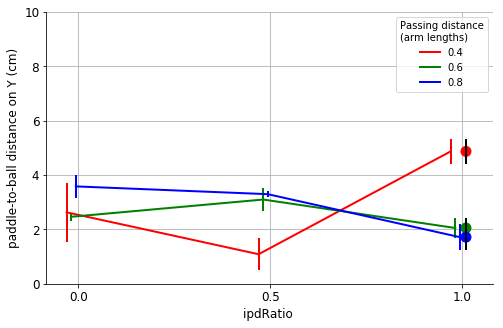

In [12]:
plotSubData = True

##############
nSubs = np.shape(catchErrX_ipd_pass_bl_sub)[3]
catchErrY_ipd_pass_bl  = np.nanmean(catchErrY_ipd_pass_bl_sub,axis=3)
stdCatchErrY_ipd_pass_bl = np.nanstd(stdCatchErrY_ipd_pass_bl_sub,axis=3) / np.sqrt(nSubs)


p, ax = plt.subplots(1, 1,) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2

bIdx = 1
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = catchErrY_ipd_pass_bl[:,pIdx,bIdx]
    yerr = stdCatchErrY_ipd_pass_bl[:,pIdx,bIdx]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
# Block 1
cList = ['r','g','b']
ax.scatter(x = [1+.01] * len(catchErrY_ipd_pass_bl[2,:,bIdx]) , 
           y = catchErrY_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(catchErrY_ipd_pass_bl[2,:,bIdx]), 
            y = catchErrY_ipd_pass_bl[2,:,bIdx],
            yerr=stdCatchErrY_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('paddle-to-ball distance on Y (cm)', fontsize=12)
ax.set_xlabel('ipdRatio ', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# ax.set_ylim([-.15,.1])
ax.set_ylim([0,10])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=12)

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)

p.set_facecolor('w')
fName = outDir + 'meanCatchingErrorY.png'
plt.savefig(fName, facecolor='w', transparent=True)


# mean catching err on X AND Y 

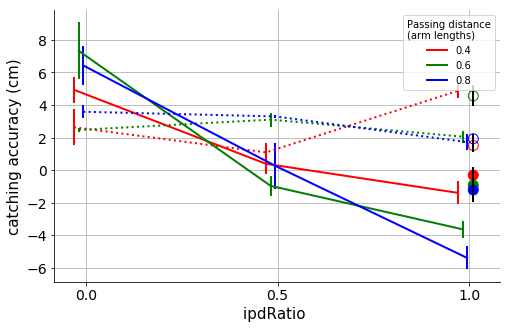

In [13]:
plotSubData = True

##############
nSubs = np.shape(catchErrX_ipd_pass_bl_sub)[3]
p, ax = plt.subplots(1, 1,) #sharey=True)

cList = ['r','g','b']
offsets = np.linspace(-.03,.03,6)
# Block 2

bIdx = 1
for pIdx, pVal in enumerate(passingLocXList):

    x = ipdRatioList + offsets[pIdx]
    y = catchErrX_ipd_pass_bl[:,pIdx,bIdx]
    yerr = stdCatchErrX_ipd_pass_bl[:,pIdx,bIdx]
    h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
    h.set_label(pVal)
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
    x = ipdRatioList + offsets[pIdx]
    y = catchErrY_ipd_pass_bl[:,pIdx,bIdx]
    yerr = stdCatchErrY_ipd_pass_bl[:,pIdx,bIdx]
    h, = ax.plot(x, y,':',linewidth=2,color = cList[pIdx])
    ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
    
############ Block 0
bIdx = 0
cList = ['r','g','b']

ax.scatter(x = [1+.01] * len(catchErrY_ipd_pass_bl[2,:,bIdx]) , 
           y = catchErrY_ipd_pass_bl[2,:,bIdx],
          s=100,facecolors="None",edgecolors=cList)#, markeredgewidth=5)

ax.errorbar(x = [1+.01] * len(catchErrY_ipd_pass_bl[2,:,bIdx]), 
            y = catchErrY_ipd_pass_bl[2,:,bIdx],
            yerr= stdCatchErrY_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

ax.scatter(x = [1+.01] * len(catchErrX_ipd_pass_bl[2,:,bIdx]) , 
           y = catchErrX_ipd_pass_bl[2,:,bIdx],
          s=100,c=cList)

ax.errorbar(x = [1+.01] * len(catchErrX_ipd_pass_bl[2,:,bIdx]), 
            y = catchErrX_ipd_pass_bl[2,:,bIdx],
            yerr= stdCatchErrX_ipd_pass_bl[2,:,bIdx] ,
            elinewidth=2,
            ecolor = 'k',fmt="none")

############

plt.gcf().set_size_inches(8,5)
ax.set_ylabel('catching accuracy (cm)', fontsize=15)
ax.set_xlabel('ipdRatio ', fontsize=15)
ax.tick_params(axis='both', which='major',labelsize=15)

# ax.set_ylim([-15,15])
plt.legend(title='Passing distance\n(arm lengths)')
ax.axes.spines['top'].set_visible(False)
ax.axes.spines['right'].set_visible(False)
ax.axes.yaxis.grid(True)
ax.axes.xaxis.grid(True)
ax.axes.set_axisbelow(True)
# ax.tick_params.labelsize(12)

plt.rcParams["font.family"] = "sans-serif"
ax.set_xticks(ipdRatioList)
ax.tick_params(axis='both', which='major', labelsize=14)

outDir = '../subFigs/'
if not os.path.exists(outDir):
    os.makedirs(outDir)

p.set_facecolor('w')
fName = outDir + 'meanCatchingErrorXandY.png'
plt.savefig(fName, facecolor='w', transparent=True)

# Catching err individual subs

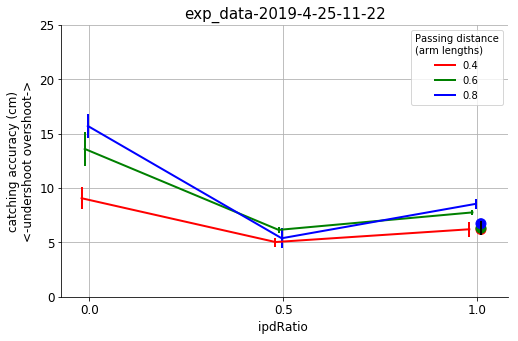

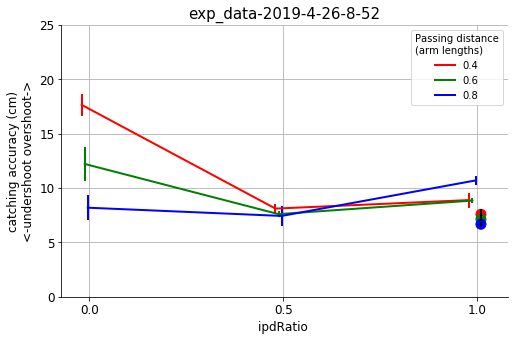

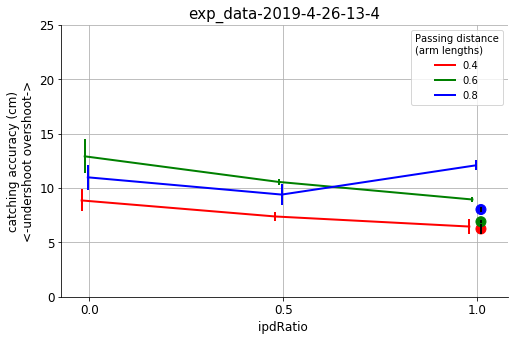

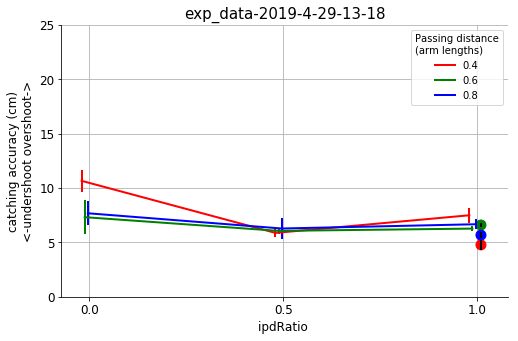

In [14]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];

for subIdx in range(np.shape(catchErr_ipd_pass_bl_sub)[3]):

    ##############
    nSubs = np.shape(catchErr_ipd_pass_bl_sub)[3]
    catchErr_ipd_pass_bl  = np.squeeze(catchErr_ipd_pass_bl_sub[:,:,:,subIdx])
    stdCatchErr_ipd_pass_bl_sub = np.nanstd(catchErr_ipd_pass_bl_sub,axis=3) 

    p, ax = plt.subplots(1, 1) #sharey=True)

    cList = ['r','g','b']
    offsets = np.linspace(-.02,.02,6)
    # Block 2
    for pIdx, pVal in enumerate(passingLocXList):

        x = ipdRatioList + offsets[pIdx]
        y = catchErr_ipd_pass_bl[:,pIdx,1]
        yerr = stdCatchErr_ipd_pass_bl[:,pIdx,1]
        h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
        h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")

    
    # Block 0
    bIdx = 0
    cList = ['r','g','b']
    ax.scatter(x = [1+.01] * len(catchErr_ipd_pass_bl[2,:,bIdx]) , 
               y = catchErr_ipd_pass_bl[2,:,bIdx],
              s=100,c=cList)

    ax.errorbar(x = [1+.01] * len(catchErr_ipd_pass_bl[2,:,bIdx]), 
                y = catchErr_ipd_pass_bl[2,:,bIdx],
                yerr=stdCatchErr_ipd_pass_bl[2,:,bIdx] ,
                elinewidth=2,
                ecolor = 'k',fmt="none")

    plt.gcf().set_size_inches(8,5)
    #pctCaught = pctCaughtB2NoExp_fileName[fileNames[subIdx]]
    ax.axes.set_title(fileNames[subIdx], fontsize=15)
    
    ax.set_ylabel('catching accuracy (cm)\n<-undershoot overshoot->', fontsize=12)
    ax.set_xlabel('ipdRatio ', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_ylim([0,25])
    plt.legend(title='Passing distance\n(arm lengths)')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    ax.axes.set_axisbelow(True)

    plt.rcParams["font.family"] = "sans-serif"
    ax.set_xticks(ipdRatioList)
    ax.tick_params(axis='both', which='major', labelsize=12)

    p.set_facecolor('w')


# Catching err X and Y axis

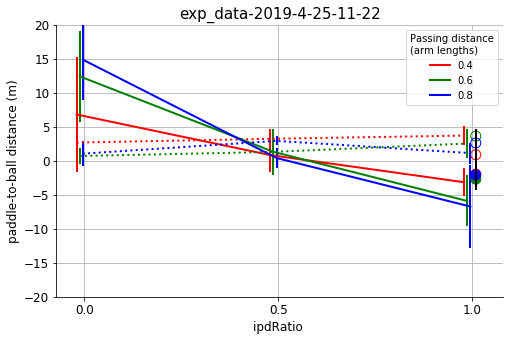

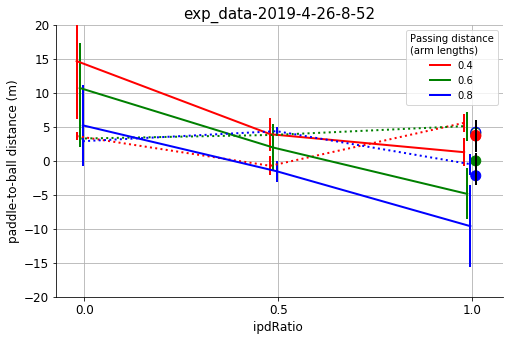

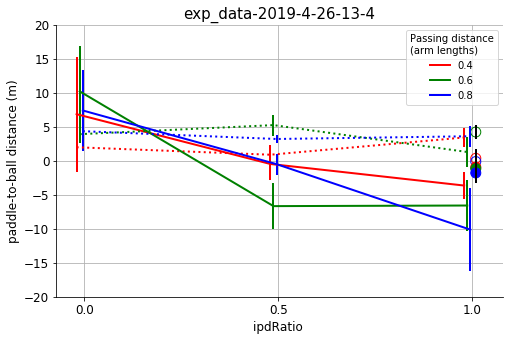

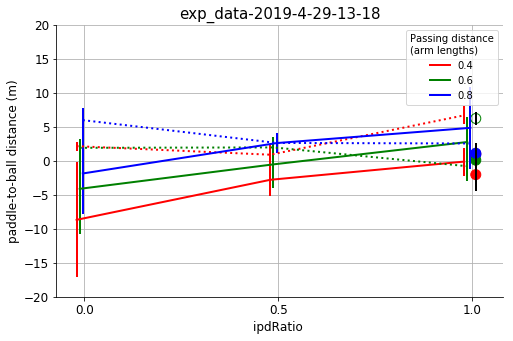

In [15]:
fileTimeList = [];
[fileTimeList.append(name) for name in os.listdir("../Data/") if name[0] is not '.'];

for subIdx in range(np.shape(catchErrX_ipd_pass_bl_sub)[3]):

    ##############
    nSubs = np.shape(catchErr_ipd_pass_bl_sub)[3]
    catchErrXss_ipd_pass_bl  = np.squeeze(catchErrX_ipd_pass_bl_sub[:,:,:,subIdx])
    stdCatchErrXss_ipd_pass_bl = np.nanstd(catchErrX_ipd_pass_bl_sub,axis=3) 
    
    catchErrYss_ipd_pass_bl  = np.squeeze(catchErrY_ipd_pass_bl_sub[:,:,:,subIdx])
    stdCatchErrYss_ipd_pass_bl = np.nanstd(catchErrY_ipd_pass_bl_sub,axis=3) 

    p, ax = plt.subplots(1, 1) #sharey=True)

    cList = ['r','g','b']
    offsets = np.linspace(-.02,.02,6)
    # Block 2
    for pIdx, pVal in enumerate(passingLocXList):

        x = ipdRatioList + offsets[pIdx]
        y = catchErrXss_ipd_pass_bl[:,pIdx,1]
        yerr = stdCatchErrXss_ipd_pass_bl[:,pIdx,1]
        h, = ax.plot(x, y,linewidth=2,color = cList[pIdx])
        h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")
        
        x = ipdRatioList + offsets[pIdx]
        y = catchErrYss_ipd_pass_bl[:,pIdx,1]
        yerr = stdCatchErrYss_ipd_pass_bl[:,pIdx,1]
        h, = ax.plot(x, y,':',linewidth=2,color = cList[pIdx])
#         h.set_label(pVal)
        ax.errorbar(x=x, y=y,yerr=yerr,elinewidth=2,ecolor = cList[pIdx],fmt="none")


    ############ Block 0
    bIdx = 0
    cList = ['r','g','b']

    ax.scatter(x = [1+.01] * len(catchErrYss_ipd_pass_bl[2,:,bIdx]) , 
               y = catchErrYss_ipd_pass_bl[2,:,bIdx],
              s=100,facecolors="None",edgecolors=cList)#, markeredgewidth=5)

    ax.errorbar(x = [1+.01] * len(catchErrYss_ipd_pass_bl[2,:,bIdx]), 
                y = catchErrYss_ipd_pass_bl[2,:,bIdx],
                yerr= stdCatchErrYss_ipd_pass_bl[2,:,bIdx] ,
                elinewidth=2,
                ecolor = 'k',fmt="none")

    ax.scatter(x = [1+.01] * len(catchErrXss_ipd_pass_bl[2,:,bIdx]) , 
               y = catchErrXss_ipd_pass_bl[2,:,bIdx],
              s=100,c=cList)

    ax.errorbar(x = [1+.01] * len(catchErrXss_ipd_pass_bl[2,:,bIdx]), 
                y = catchErrXss_ipd_pass_bl[2,:,bIdx],
                yerr= stdCatchErrXss_ipd_pass_bl[2,:,bIdx] ,
                elinewidth=2,
                ecolor = 'k',fmt="none")

    plt.gcf().set_size_inches(8,5)
    ax.axes.set_title(fileNames[subIdx], fontsize=15)
    
    ax.set_ylabel('paddle-to-ball distance (m)', fontsize=12)
    ax.set_xlabel('ipdRatio ', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

    ax.set_ylim([-20,20])
    plt.legend(title='Passing distance\n(arm lengths)')
    ax.axes.spines['top'].set_visible(False)
    ax.axes.spines['right'].set_visible(False)
    ax.axes.yaxis.grid(True)
    ax.axes.xaxis.grid(True)
    ax.axes.set_axisbelow(True)

    plt.rcParams["font.family"] = "sans-serif"
    ax.set_xticks(ipdRatioList)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    #plt.title(fileNames_sub[subIdx])
    p.set_facecolor('w')
    
    outDir = '../subFigs/'
    if not os.path.exists(outDir):
        os.makedirs(outDir)

    fName = outDir + 'catchingDistOnXandY_' + fileTimeList[subIdx] + '.png'
    plt.savefig(fName, facecolor=p.get_facecolor(), transparent=True)
